In [1]:
import numpy as np
from keras.layers import Dense
import tensorflow as tf
from tensorflow.keras.optimizers  import Adam
from keras import Sequential
import pybullet as p
import time
import pybullet_data
import matplotlib.pyplot as plt
from keras.losses import Huber
from  keras.models import load_model

In [2]:
class PybulletConnection(object):

    def __init__(self , render):
        
        try : p.disconnect()
        except : pass
        if render:
            physicsClient = p.connect(p.GUI) 
        else : 
            physicsClient = p.connect(p.DIRECT)
        p.setAdditionalSearchPath(pybullet_data.getDataPath())
        p.createCollisionShape(p.GEOM_PLANE)
        p.createMultiBody(0, 0)
        p.setGravity(0,0,-9.8)
        startPos = [0,0,0]
        startOrientation = p.getQuaternionFromEuler([0,0,0])
        self.bodyObj = p.loadURDF("balancebot_simple.xml" 
                               , startPos , startOrientation)
        
    def resetEnvironment(BalancingRobot):
        p.resetSimulation()
        p.setAdditionalSearchPath(pybullet_data.getDataPath())
        p.createCollisionShape(p.GEOM_PLANE)
        p.createMultiBody(0, 0)
        p.setGravity(0,0,-9.8)
        startPos = [0,0,0]
        startOrientation = p.getQuaternionFromEuler([0,0,0])
        bodyObj = p.loadURDF("balancebot_simple.xml" 
                               , startPos , startOrientation) 
        return 0
class BalancingRobot(PybulletConnection):
    
    actions_dect = {0 : [10,-10] , 1:[20, -20] , 2:[30 , -30] , 3: [40,-40] , 4 :[50 , -50 ] ,
               4  : [-10 , 10] , 5:[-20 , 20] , 6:[-30, 30] , 7 : [-40 , 40] , 8 : [-50 , 50] }    
    
    def __init__(self , r):
        self.reward = 0
        super().__init__(render=r)
        self.motor1 = MotorDC(0 , self.bodyObj)
        self.motor2 = MotorDC(1 , self.bodyObj)
        self.BASE_LINK_INDEX = 0
        
    def controlMotors(self, vel):
        
        self.motor1.currentVelocity = vel[0]
        self.motor2.currentVelocity = vel[1]
        
        p.setJointMotorControlArray(
                bodyIndex = self.bodyObj,
                jointIndices = [self.motor1.motor_index , self.motor2.motor_index],
                controlMode = p.VELOCITY_CONTROL,      
                targetVelocities=vel) 
              
    
    def isTerminalState(self):
        cubePos, _ = p.getBasePositionAndOrientation(self.bodyObj)
        
        return cubePos[2] < 0.15
    
    def read_State(self):
        x_orientation = p.getEulerFromQuaternion(p.getBasePositionAndOrientation(self.bodyObj)[1])[0]
    
        if x_orientation > 0 and x_orientation <= 0.25:
            return 0
    
        if x_orientation >= 0.25 and x_orientation <=0.5:
            return 1
        
        elif x_orientation > 0.5:
            return 2
    
        elif x_orientation < 0 and x_orientation >= -0.25:
            return 3
        
        elif x_orientation < -0.25 and x_orientation >= -0.5:
            return 4
        
        else : return 5
        
    def takeActionFromList(self,velocity):
        self.controlMotors(velocity)
        p.stepSimulation()
        if self.isTerminalState():
            self.reward -= 1000
        else :
            self.reward +=0.1
                
    def calculate_reward(self):
        return self.reward
    
    def step(self , action_index):
        
        velocity_list=BalancingRobot.actions_dect[action_index]
        self.takeActionFromList(velocity_list)
        new_state= self.read_State()
        r=self.calculate_reward()
        
        if self.isTerminalState():
            self.reward=0
            self.resetEnvironment()
            
        return (new_state , r)
class MotorDC(object):
    
    def __init__(self , motor_index , bodyObj):
        
        self.motor_index=motor_index
        self.bodyObj= bodyObj
        self.currentVelocity = 0

In [41]:
class ExpMemory(object):
    def __init__(self, memory_size , input_shape ):
        
        self.input_shape = input_shape
        self.memory_size = memory_size
        self.memory = np.zeros((self.memory_size , self.input_shape))
        self.memory_count = 0
        
    def store_replay(self , state , actionIndex , reward , new_state  ):
        if self.memory_count < self.memory_size :
            self.memory[self.memory_count] = (state , actionIndex , reward , new_state )
            self.memory_count += 1
        else : 
            raise BufferError("Memory is Full")
        
    def sample_batch(self , batch_size):
        current_memory_size = self.memory_count
        batch_indecies = np.random.choice(self.memory_count , batch_size)
        return self.memory[batch_indecies]
    
class Qnetwork(object):

    def __init__(self, state_shape , n_actions , lr , fc1 , fc2):
        self.lr = lr
        self.n_actions= n_actions
        self.state_shape=state_shape
        self.model = Sequential([
            Dense(fc1 , activation = 'relu' , input_shape = ( self.state_shape ,)) ,
            #Dense(fc2 , activation = 'relu'),
            Dense(n_actions , activation = 'relu')
        ])
        self.model.compile( optimizer = Adam(learning_rate=lr) , loss=Huber() )
        
    def get_Model(self):
        return self.model
    
class DoubleDQNAgent(object):
    def __init__(self, discount_rate , alpha , epsilon , memory_size  
                 , n_actions , input_shape, lr , memory_shape ,  batch_size , decay_rate = 0):
        self.discount_rate = discount_rate
        self.alpha = alpha
        self.epsilon = 1
        self.memory_size = memory_size
        self.n_actions= n_actions
        self.input_shape = input_shape
        self.lr=lr
        self.memory_shape = memory_shape
        
        self.replay_memory = ExpMemory(self.memory_size , memory_shape )
        
        self.q_eval = Qnetwork(self.input_shape , self.n_actions 
                                  , self.lr , fc1=5 , fc2=10).get_Model()
        
        self.q_target = Qnetwork(self.input_shape , self.n_actions 
                                 , self.lr , fc1 =5 , fc2=10).get_Model()
        self.batch_size = batch_size
        self.decay_rate= decay_rate
        self.tau = 0.001
        self.train_rewards = []
        self.maximum_q = []
    def epsilon_greedy(self,state):
        if  np.random.rand(1) < self.epsilon:
            actions = self.q_eval.predict(state)
            action = np.argmax(actions)
            self.maximum_q.append(np.max(actions))
        else:
            action = np.random.randint(0, self.n_actions)
        return action
        
    def learn(self , myRobot):
        current_state = myRobot.resetEnvironment()
        batch_index=np.arange(self.batch_size)
        
        for i in range(self.batch_size):
            action = self.epsilon_greedy(np.array([current_state]))
            new_state , reward = myRobot.step(action)
            self.replay_memory.store_replay(current_state , action , reward , new_state)
            current_state = new_state
        
        for i in range(10000):
                action = self.epsilon_greedy(np.array([current_state]))
                new_state , reward = myRobot.step(action)
                self.replay_memory.store_replay(current_state , action , reward , new_state)
                batch = self.replay_memory.sample_batch(self.batch_size)
                
                state_batch = batch[: , 0]
                new_state_batch = batch[: , 3]
                actionIndecies_batch = batch[: , 1]
                reward = batch[: , 2]
                
                # THE ALGORITHM
                
                Qs = self.q_eval.predict(state_batch)
                Q_newstate = self.q_target.predict(new_state_batch)                
                
                max_actions=np.argmax(Q_newstate , axis=1)
                target = Qs.copy()
                
                target[batch_index , actionIndecies_batch.astype(np.int16)] = \
                reward + self.discount_rate * Q_newstate[batch_index , max_actions.astype(np.int16)]
                
                if self.replay_memory.memory_count % 250 ==0:
                    self.hard_update_q_target()
                
                self.q_eval.fit(state_batch , target , verbose=False)
                
                current_state = new_state
                
                self.train_rewards.append(reward)

                if i%200 == 0 :
                    print("Average Q Values for i = " , i  , " -- > ", np.average(self.maximum_q))
                    
    def soft_update_q_target(self):
        self.tau = 0.001
        w = self.q_eval.get_weights()
        final_w = [ ]
        for i in range(len(w)):
            w[i] = w[i]*self.tau
        
        w_dash = self.q_target.get_weights()
        
        for i in range(len(w_dash)):
            w_dash[i] = w_dash[i] * (1 - self.tau)
        
        for i in range(len(w)):
            final_w.append((w[i]+ w_dash[i]))
        self.q_target.set_weights(final_w)
        
    def hard_update_q_target(self):
        self.q_target.set_weights(self.q_eval.get_weights())
        
    def test(self,  myRobot):
        self.q_eval = load_model("dqn_model.h5")
        state = myRobot.resetEnvironment()
        test_rewards = []
        for i in range(100):
            action = self.epsilon_greedy(np.array([state]))
            new_state , reward = myRobot.step(action)
            state = new_state
            test_rewards.append(reward)
        return test_rewards
                
    def save_model(self , filename):
        self.q_eval.save(filename)

    def load_model(self):
        self.q_eval = load_model("dqn_model.h5")

In [42]:
myRobot = BalancingRobot(False)

In [43]:
agent = DoubleDQNAgent(discount_rate=0.9 , alpha=0 , epsilon=0.7
                 , memory_size=1000000 , n_actions=9 , input_shape = 1 ,
                 lr = 0.01 , memory_shape=4 , batch_size=164)
agent.learn(myRobot)

Average Q Values for i =  0  -- >  0.20673157
Average Q Values for i =  200  -- >  11.839232
Average Q Values for i =  400  -- >  16.335943
Average Q Values for i =  600  -- >  20.719683
Average Q Values for i =  800  -- >  24.140646
Average Q Values for i =  1000  -- >  28.716799
Average Q Values for i =  1200  -- >  35.24611
Average Q Values for i =  1400  -- >  43.17174
Average Q Values for i =  1600  -- >  52.806755
Average Q Values for i =  1800  -- >  64.9477
Average Q Values for i =  2000  -- >  78.63951
Average Q Values for i =  2200  -- >  93.97892
Average Q Values for i =  2400  -- >  110.83561
Average Q Values for i =  2600  -- >  129.09584
Average Q Values for i =  2800  -- >  149.967
Average Q Values for i =  3000  -- >  172.59943
Average Q Values for i =  3200  -- >  196.3103
Average Q Values for i =  3400  -- >  221.08255
Average Q Values for i =  3600  -- >  246.7356
Average Q Values for i =  3800  -- >  274.30344
Average Q Values for i =  4000  -- >  303.1645
Average Q

Text(0, 0.5, 'Reward Value')

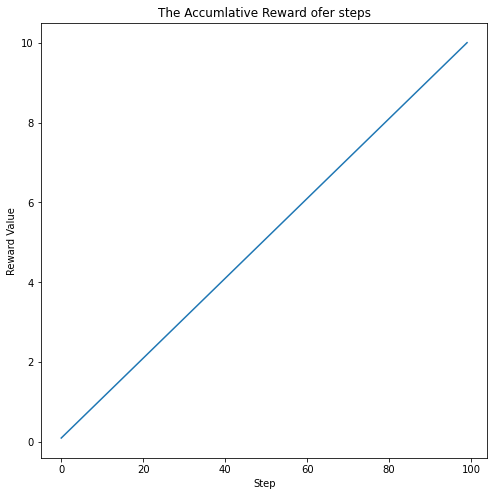

In [55]:
myRobot = BalancingRobot(False)
test_rewards = agent.test(myRobot)
plt.figure(figsize=(8,8))
plt.plot(test_rewards)
plt.title("The Accumlative Reward ofer steps")
plt.xlabel("Step")
plt.ylabel("Reward Value")

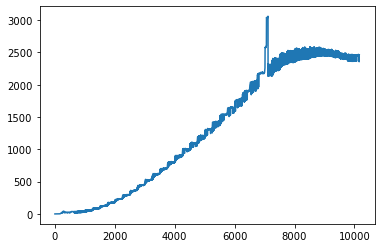

In [44]:
plt.plot(agent.maximum_q)

In [49]:
k = np.ones(100)/100
smoothed = np.convolve(np.array(agent.train_rewards).flatten(), k, 'valid')

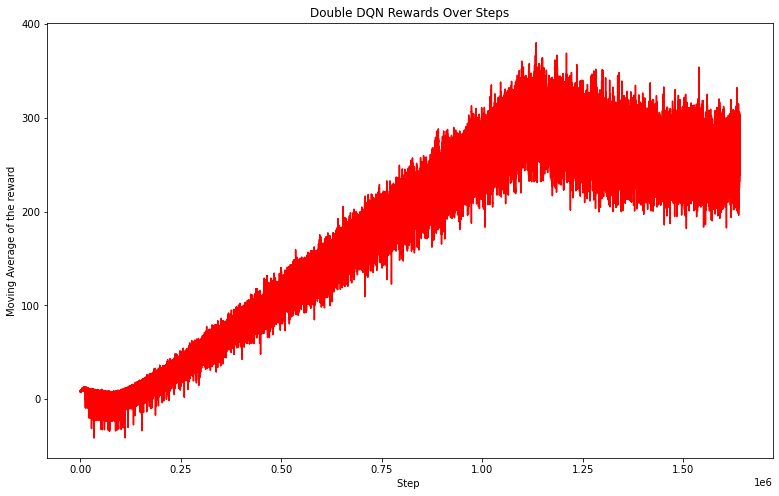

In [50]:
plt.figure(figsize=(13,8))
plt.title("Double DQN Rewards Over Steps")
plt.xlabel("Step ")
plt.ylabel("Moving Average of the reward")
plt.plot(np.arange(len(smoothed)) , smoothed , color='r' , linestyle=None)

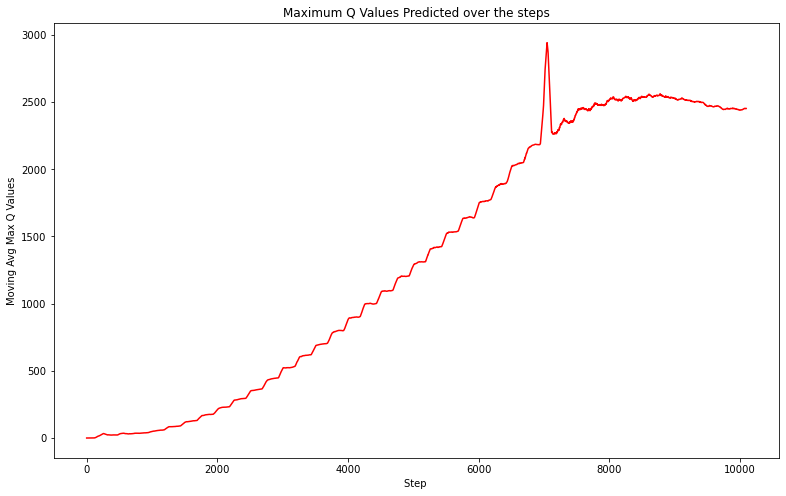

In [47]:

k = np.ones(70)/70
smoothed = np.convolve(agent.maximum_q, k, 'valid')
plt.figure(figsize=(13,8))
plt.title("Maximum Q Values Predicted over the steps")
plt.xlabel("Step ")
plt.ylabel("Moving Avg Max Q Values")
plt.plot(np.arange(len(smoothed)) , smoothed , color='r' , linestyle=None)